# PROJEK AKHIR KECERDASAN BUATAN
## 2109106006 --> Kania Putri Ananda
## 2109106012 --> Nurmedina Maulidiah
## 2109106025 --> Rismayanti

## Import Library

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
import random
import seaborn as sns
from keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

## Data Collecting

Sumber Dataset = https://www.kaggle.com/datasets/phylake1337/fire-dataset

## Data Preprocessing

In [3]:
path = 'D:/Datasets/fire_dataset/'
path_baru = 'Dataset_Split/'
classes = ['fire_images', 'non_fire_images']

In [ ]:
for cls in classes:
    os.makedirs(path + path_baru+ 'training/' + cls)
    os.makedirs(path + path_baru + 'validation/' + cls)

In [ ]:
for cls in classes:
    temp = path + cls #folder untuk copy gambar
    print(temp)

    all_dataset = os.listdir(temp)
    np.random.shuffle(all_dataset)

    #80% untuk training sisanya validasi
    dataset_train, dataset_val = np.split(np.array(all_dataset),[int(len(all_dataset)*0.80)])

    #mengubah nama file
    dataset_train = [temp +'/'+ name for name in dataset_train]
    dataset_val = [temp+'/' + name for name in dataset_val]
    
    #copy gambar ke folder tujuan
    for name in dataset_train:
        shutil.copy(name, path + path_baru+'training/'+cls )


    for name in dataset_val:
        shutil.copy(name, path + path_baru+'validation/'+cls )



In [5]:
dataset_train = image_dataset_from_directory(
    'fire_dataset/Dataset_Split/training/',
    labels = 'inferred',
    label_mode = 'int',
    color_mode='rgb',
    class_names = ['fire_images','non_fire_images'],
    image_size = (100, 100),
    shuffle = True,
    seed = 2,
    validation_split = 0.1,
    batch_size = 8,
    subset = 'training'
)

dataset_validation = image_dataset_from_directory(
    'fire_dataset/Dataset_Split/validation/',
    labels = 'inferred',
    label_mode = 'int',
    color_mode='rgb',
    class_names = ['fire_images','non_fire_images'],
    image_size = (100, 100),
    shuffle = True,
    seed = 2,
    validation_split = 0.1,
    batch_size = 8,
    subset = 'validation'
)

Found 960 files belonging to 2 classes.
Using 864 files for training.
Found 361 files belonging to 2 classes.
Using 36 files for validation.


## Data Analisis dan Visualisasi

In [6]:
class_names = dataset_train.class_names
class_names

['fire_images', 'non_fire_images']

### Visualisasi Dataset

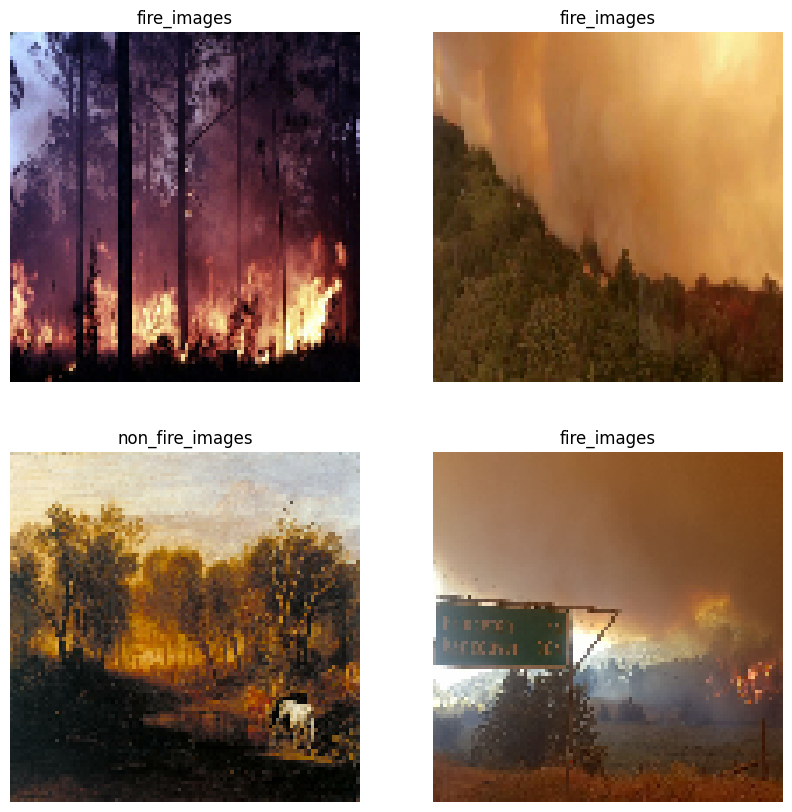

In [7]:
plt.figure(figsize=(10,10))

for images, labels in dataset_train.take(1):
    for i in range(4):
        ax = plt.subplot(2,2, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## Augmentasi Gambar

In [10]:
def augment(x, y):
    image = tf.image.random_brightness(x, max_delta = 0.5)
    return image, y

def standard(x,y) :
    images = tf.image.per_image_standardization(x)
    return images,y

In [11]:
val = dataset_validation.map(standard)
val = val.map(augment)

train = dataset_train.map(standard)
train = train.map(augment)

## Data Modelling

### Arsitektur model

In [12]:
model = Sequential([
    Conv2D(256, (3,3), activation = 'relu', input_shape=[100, 100, 3]),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(), 
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
]
)

###  Parameter Training

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0

### Konfigurasi Model

In [17]:

# Fungsi callback untuk menghentikan proses training jika sudah mendapatkan accuracy & val_acc yang diinginkan

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}): 
        if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95):
            self.model.stop_training = True
cb = myCallback()

In [18]:
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
hasil = model.fit(train, 
         validation_data = val,
         epochs = 10,
         callbacks = cb,
         verbose = 1
         )

Epoch 1/10
 85/108 [======================>.......] - ETA: 17s - loss: 0.2982 - accuracy: 0.8868

## Save Model

In [ ]:
model.save('model_fire.h5')

## Evaluasi

### Evaluasi Akurasi dan Loss

In [56]:
model.evaluate(val, verbose=1)

12/12 [==============================] - 5s 196ms/step - loss: 0.3439 - accuracy: 0.9062


[0.3438761234283447, 0.90625]

### Visualisasi Hasil Training (train dan val)

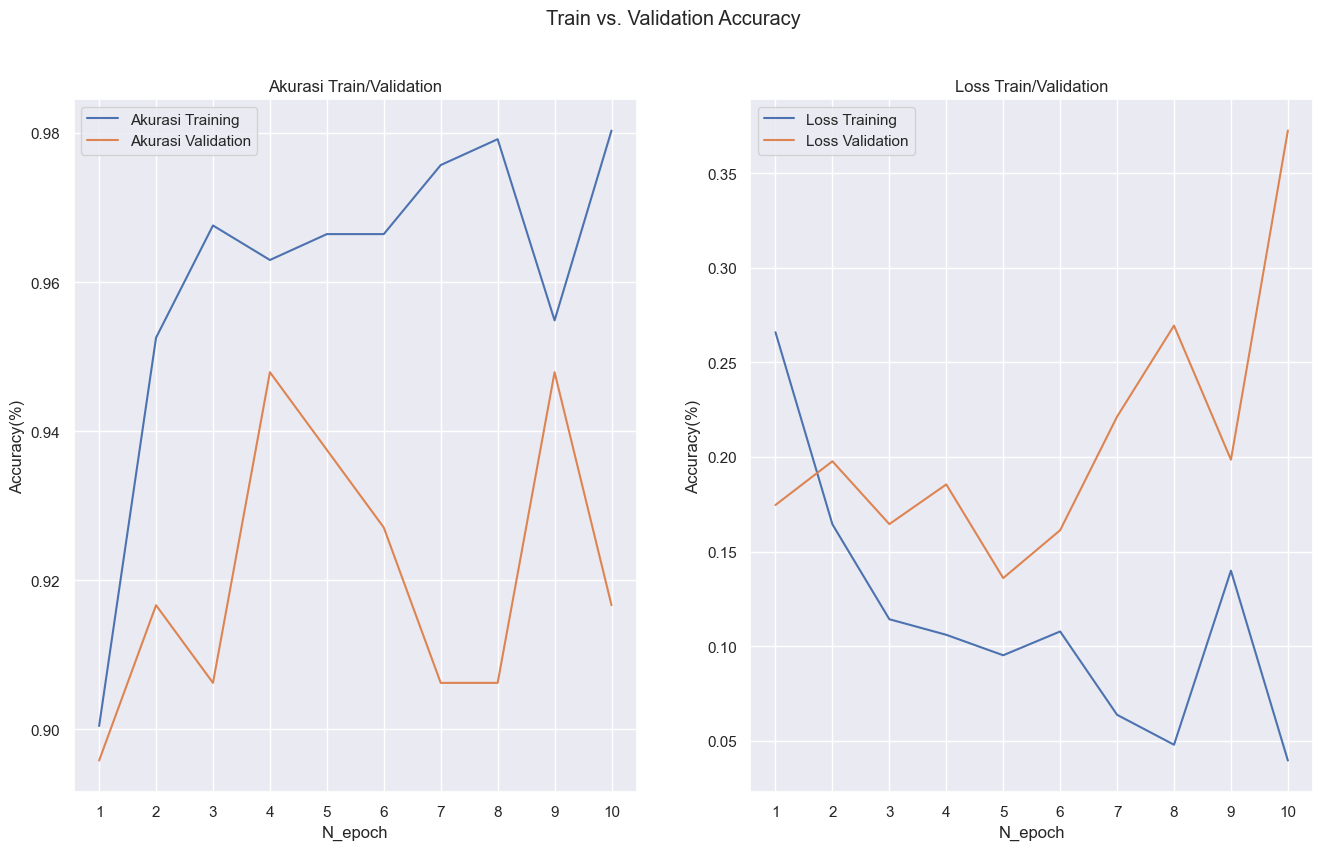

In [ ]:
epoch = [i+1 for i in range(10)]
sns.set_theme()
plt.figure(figsize = (16,9))
plt.suptitle('Train vs. Validation Accuracy')

#subplot Akurasi
plt.subplot(1,2,1)
sns.lineplot(x=epoch, y=hasil.history['accuracy'], label = "Akurasi Training")
sns.lineplot(x=epoch, y=hasil.history['val_accuracy'], label = "Akurasi Validation")

plt.xticks(epoch)
plt.xlabel('N_epoch')
plt.ylabel('Accuracy(%)')
plt.title('Akurasi Train/Validation')

#subplot Loss
plt.subplot(1,2,2)
sns.lineplot(x=epoch, y=hasil.history['loss'], label = "Loss Training")
sns.lineplot(x=epoch, y=hasil.history['val_loss'], label = "Loss Validation")

plt.xticks(epoch)
plt.xlabel('N_epoch')
plt.ylabel('Accuracy(%)')
plt.title('Loss Train/Validation')

plt.show()

### Evaluasi Model

1/1 [==============================] - 0s 72ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 65ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 65ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 77ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 70ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 70ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


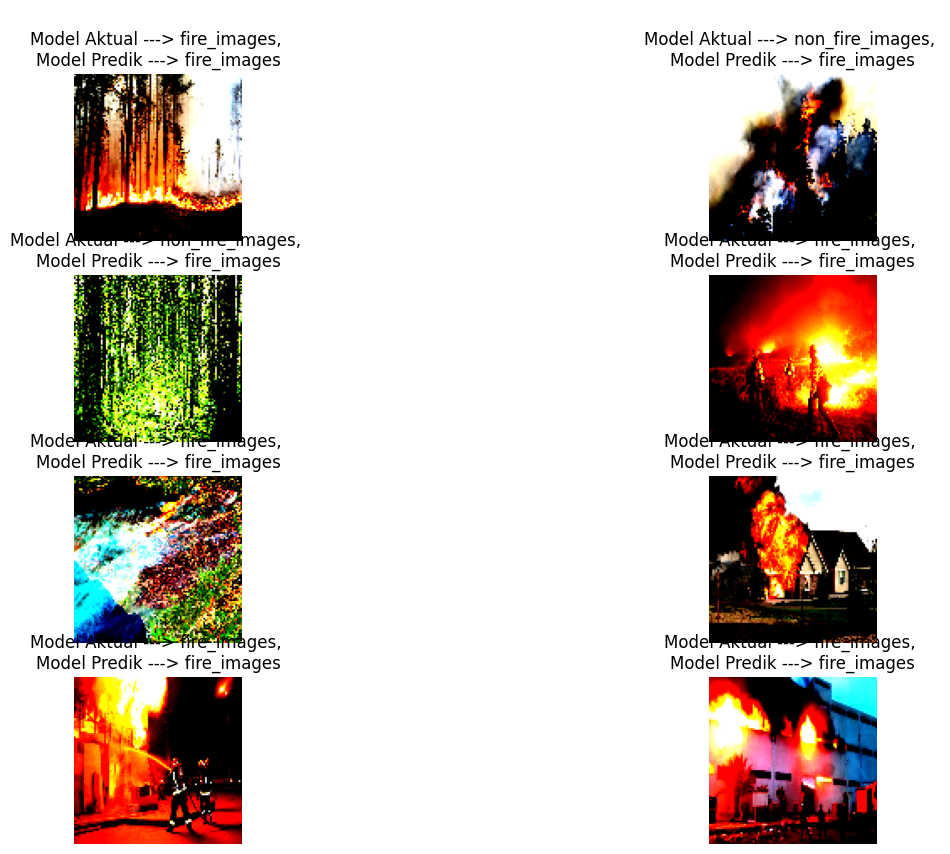

In [57]:
image, label = next(iter(val))

plt.figure(figsize=(15,10))
for images, labels in dataset_train.take(1):
    for i in range(8) :
        plt.subplot(4,2,i+1)
        plt.axis('off')
        predict = np.argmax(model.predict(image[i][None]))
        plt.imshow(tf.squeeze(image[i]))
        plt.title(f'\nModel Aktual ---> {class_names[label[i]]}, \nModel Predik ---> {class_names[predict]}')